# Akari
---

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns 
import os

plt.rc('font', size=6)
sns.set()

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from dateutil.parser import parse

In [3]:
DATA_DIR = '../data/AAPL/prices.csv'

In [4]:
df = pd.read_csv(DATA_DIR)

In [5]:
df.head()

,Date,Close,Volume,Open,High,Low
0,1361923200000000000,15.8775,586219246,16.0154,16.1586,15.7375
1,1362009600000000000,15.7643,322049711,15.8589,15.9954,15.7643
2,1362096000000000000,15.3739,551278339,15.6429,15.6493,15.3564
3,1362355200000000000,15.0018,577328969,15.2786,15.2929,14.9643
4,1362441600000000000,15.3980,636908185,15.0529,15.5425,15.0268


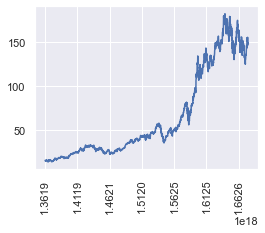

In [6]:
# Visualizing Closing Prices
fig = plt.figure(figsize=(4, 3))
plt.xticks(df['Date'][::400], rotation=90)
plt.plot(df['Date'], df['Close'])

In [7]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [8]:
features = ['Close', 'Open']
data_raw = df[features].values.reshape(-1,len(features))
print(data_raw.shape)

(2517, 2)


In [9]:
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(data_raw)
print(data_scaled)

[[0.01148382 0.01279404]
 [0.01081026 0.01186676]
 [0.00848732 0.01058695]
 ...
 [0.80304946 0.79996907]
 [0.80596504 0.80719768]
 [0.78995909 0.78954092]]


In [10]:
TRAIN_SIZE = 0.80

train_size = int(len(data_scaled) * TRAIN_SIZE)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size, :], data_scaled[train_size:len(data_scaled), :]

print(f'Train size: {len(train)}')
print(f'Test size: {len(test)}')

Train size: 2013
Test size: 504


In [11]:
WINDOW_SIZE = 1
def create_dataset(dataset):
    data_X, data_Y = [], []
    for i in range(len(dataset) - WINDOW_SIZE):
        data_X.append(dataset[i:(i + WINDOW_SIZE),:])
        data_Y.append(dataset[i + WINDOW_SIZE,:])
    return(np.array(data_X), np.array(data_Y))

In [12]:
train_X, train_Y = create_dataset(train)
test_X, test_Y = create_dataset(test)
print(f'Initial training data shape: {train_X.shape}')
print(f'Initial test data shape: {train_Y.shape}')

Initial training data shape: (2012, 1, 2)
Initial test data shape: (2012, 2)


In [140]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(30))
model.add(Dense(train_X.shape[2]))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 1, 100)            41200     
                                                                 
 lstm_41 (LSTM)              (None, 50)                30200     
                                                                 
 dense_33 (Dense)            (None, 30)                1530      
                                                                 
 dense_34 (Dense)            (None, 2)                 62        
                                                                 
Total params: 72,992
Trainable params: 72,992
Non-trainable params: 0
_________________________________________________________________


In [141]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers

steps_per_epoch = len(train) // 32
boundaries = [steps_per_epoch * n for n in [100,200,300]]
values = [1e-3, 3e-4, 3e-5, 1e-5]
lr_sched = optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer = optimizers.Adam(lr_sched)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [142]:
model.fit(train_X, train_Y, epochs=400, batch_size=32, verbose=2)

Epoch 1/400
63/63 - 8s - loss: 0.0173 - 8s/epoch - 130ms/step
Epoch 2/400
63/63 - 0s - loss: 1.9819e-04 - 460ms/epoch - 7ms/step
Epoch 3/400
63/63 - 0s - loss: 8.5141e-05 - 423ms/epoch - 7ms/step
Epoch 4/400
63/63 - 0s - loss: 6.9408e-05 - 408ms/epoch - 6ms/step
Epoch 5/400
63/63 - 0s - loss: 5.7065e-05 - 395ms/epoch - 6ms/step
Epoch 6/400
63/63 - 0s - loss: 5.3250e-05 - 397ms/epoch - 6ms/step
Epoch 7/400
63/63 - 0s - loss: 4.7719e-05 - 404ms/epoch - 6ms/step
Epoch 8/400
63/63 - 0s - loss: 4.4712e-05 - 389ms/epoch - 6ms/step
Epoch 9/400
63/63 - 0s - loss: 4.2018e-05 - 395ms/epoch - 6ms/step
Epoch 10/400
63/63 - 0s - loss: 4.0776e-05 - 387ms/epoch - 6ms/step
Epoch 11/400
63/63 - 0s - loss: 4.1870e-05 - 396ms/epoch - 6ms/step
Epoch 12/400
63/63 - 0s - loss: 4.0159e-05 - 400ms/epoch - 6ms/step
Epoch 13/400
63/63 - 0s - loss: 4.2507e-05 - 396ms/epoch - 6ms/step
Epoch 14/400
63/63 - 0s - loss: 4.0485e-05 - 408ms/epoch - 6ms/step
Epoch 15/400
63/63 - 0s - loss: 4.5991e-05 - 415ms/epoch - 7ms

In [143]:
def predict_and_score(model, X, Y):
    pred_scaled = model.predict(X)
    pred = scaler.inverse_transform(pred_scaled)
    orig_data = scaler.inverse_transform(Y)
    score = math.sqrt(mean_squared_error(orig_data[:,0], pred[:,0]))
    return(score, pred)

In [144]:
rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

print(f"Training RMSE: {rmse_train} RMSE")
print(f"Test RMSE: {rmse_test} RMSE")

Training RMSE: 1.1099979515272749 RMSE
Test RMSE: 2.9960393380127637 RMSE
